# Radial Velocities for quiet-Sun Days

In [81]:
import os
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import tamar.tools.utilities as utils
import tamar.tools.plotting_funcs as plot
from tamar.tools.settings import CsvDir, ImgDir
from sklearn.linear_model import LinearRegression

In [82]:
csv_file = os.path.join(CsvDir.NEID_CALC, 'rvs_from_txt.csv')


In [83]:
# create pandas dataframe
component_df = pd.read_csv(csv_file)

# get dates list
date_jd = component_df.date_jd.values
inds = np.argsort(date_jd)

In [84]:
# get rvs and error
rv_sun = component_df.rv_sun.values[inds]
rv_error = component_df.rv_error.values[inds]

# get dates with good rvs
non_nan = np.logical_not(np.isnan(rv_sun))

rv_med = np.nanmedian(np.abs(rv_sun))

good_sun = np.logical_and(np.abs(rv_sun) > rv_med - 2, np.abs(rv_sun) < rv_med + 2)
good_error = np.logical_and(np.abs(rv_error) < .4, np.abs(rv_error) < .225)
good = np.logical_and(good_sun, good_error)

good_rvs = np.logical_and(good, non_nan)

In [85]:
# dates
date_jd = date_jd[inds][good_rvs]
dates = component_df.date_obs.values[inds][good_rvs]

# get velocities lists
v_phot = component_df.v_phot.values[inds][good_rvs]
v_conv = component_df.v_conv.values[inds][good_rvs]
rv_model = component_df.rv_model.values[inds][good_rvs]
rv_sun = rv_sun[good_rvs]
rv_error = rv_error[good_rvs]
v_quiet = component_df.v_quiet.values[inds][good_rvs]
v_disc = component_df.v_disc.values[inds][good_rvs]

# get magnetic observables
Bobs = component_df.Bobs.values[inds][good_rvs]
f = component_df.f.values[inds][good_rvs]
f_bright = component_df.f_bright.values[inds][good_rvs]
f_spot = component_df.f_spot.values[inds][good_rvs]

Days with no sunspots.

In [86]:
no_spots = np.where(f_spot == 0)

date_jd = date_jd[no_spots]
v_phot = v_phot[no_spots]
v_conv = v_conv[no_spots]
rv_sun = rv_sun[no_spots]
rv_model = rv_model[no_spots]
Bobs = Bobs[no_spots]
f = f[no_spots]
f_bright = f_bright[no_spots]
f_spot = f_spot[no_spots]

## Calculate model RV

In [87]:
# make arrays
X = np.zeros(shape=(len(rv_sun), 2))
X[:, 0] = v_phot
X[:, 1] = v_conv
y = rv_sun

# apply regression
reg = LinearRegression(positive=True).fit(X, y)

# get scaling factors
A = reg.coef_[0]
B = reg.coef_[1]
RV0 = reg.intercept_


# # calculate the Model RV for the milbourne data using these coefficients
rv_model = A*v_phot + B*v_conv + RV0

print('A:', A, ', B:', B, ', RV0:', RV0)

A: 0.39176851803559953 , B: 0.5173200559152022 , RV0: -641.8636158378438


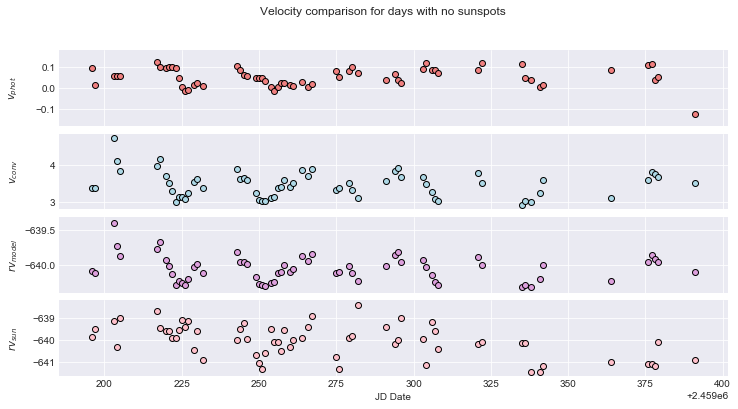

In [88]:
x = date_jd
y_list = [v_phot, v_conv, rv_model, rv_sun]
xlabel = 'JD Date'
ylabel_list = ['$v_{phot}$', '$v_{conv}$', '$rv_{model}$', '$rv_{sun}$']
title = 'Velocity comparison for days with no sunspots'

plot.vert_comp_timeseries(x, y_list, title, xlabel, ylabel_list)

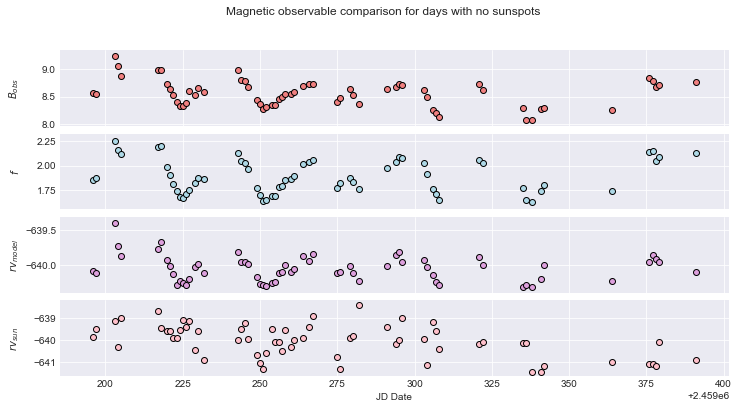

In [89]:
x = date_jd
y_list = [Bobs, f, rv_model, rv_sun]
xlabel = 'JD Date'
ylabel_list = ['$B_{obs}$', '$f$', '$rv_{model}$', '$rv_{sun}$']
title = 'Magnetic observable comparison for days with no sunspots'

plot.vert_comp_timeseries(x, y_list, title, xlabel, ylabel_list)

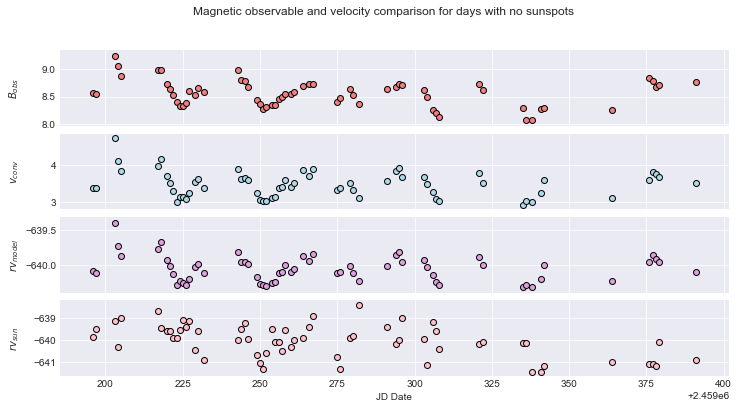

In [90]:
x = date_jd
y_list = [Bobs, v_conv, rv_model, rv_sun]
xlabel = 'JD Date'
ylabel_list = ['$B_{obs}$', '$v_{conv}$', '$rv_{model}$', '$rv_{sun}$']
title = 'Magnetic observable and velocity comparison for days with no sunspots'

plot.vert_comp_timeseries(x, y_list, title, xlabel, ylabel_list)


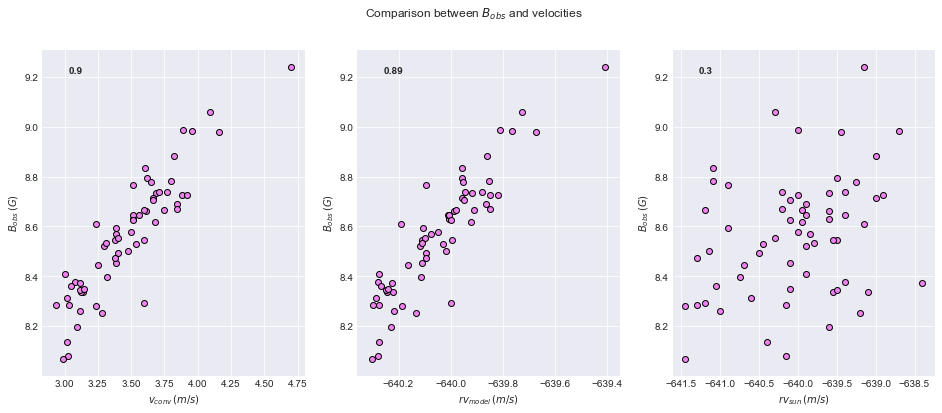

In [91]:
x_list = [v_conv, rv_model, rv_sun]
y_list = [Bobs, Bobs, Bobs]
xlabel_list = ['$v_{conv} \/(m/s)$', '$rv_{model} \/(m/s)$', '$rv_{sun} \/(m/s)$']
ylabel_list = ['$B_{obs} \/(G)$', '$B_{obs} \/(G)$', '$B_{obs} \/(G)$']
title = 'Comparison between $B_{obs}$ and velocities'
# save_fig = os.path.join(ImgDir.MIL_IMG, 'comp_ref_calc_vels.png')

# calculate correlation coefficient
corr_one = stats.spearmanr(x_list[0], y_list[0])
corr_two = stats.spearmanr(x_list[1], y_list[1])
corr_three = stats.spearmanr(x_list[2], y_list[2])

# setup the plot
fig, axs = plt.subplots(1, 3, figsize=[16, 6], gridspec_kw={'wspace': 0.2})
fig.suptitle(title)
axs[0].set(xlabel=xlabel_list[0], ylabel=ylabel_list[0])
axs[1].set(xlabel=xlabel_list[1], ylabel=ylabel_list[1])
axs[2].set(xlabel=xlabel_list[2], ylabel=ylabel_list[2])

# plot data
axs[0].scatter(x_list[0], y_list[0], color='violet', edgecolors='k', linewidths=1.0)
axs[1].scatter(x_list[1], y_list[1], color='violet', edgecolors='k', linewidths=1.0)
axs[2].scatter(x_list[2], y_list[2], color='violet', edgecolors='k', linewidths=1.0)

# label correlation coefficients
axs[0].text(0.1, 0.95, str(np.around(corr_one[0], 2)), horizontalalignment='left',
            verticalalignment='top', transform=axs[0].transAxes, weight='bold')
axs[1].text(0.1, 0.95, str(np.around(corr_two[0], 2)), horizontalalignment='left',
            verticalalignment='top', transform=axs[1].transAxes, weight='bold')
axs[2].text(0.1, 0.95, str(np.around(corr_three[0], 2)), horizontalalignment='left',
            verticalalignment='top', transform=axs[2].transAxes, weight='bold')

# remove tick marks
for ax in axs:
    ax.tick_params(labelbottom=True)

# save if needed
# if save_fig is not None:
#     plt.savefig(save_fig)

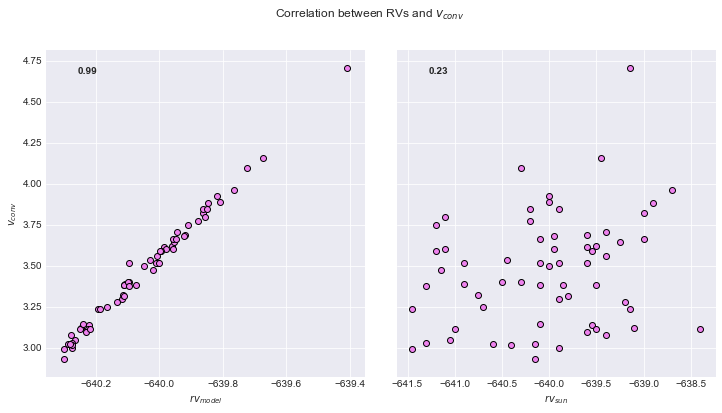

In [92]:
x_list = [rv_model, rv_sun]
y = v_conv
title = 'Correlation between RVs and $v_{conv}$'
xlabel_list = ['$rv_{model}$', '$rv_{sun}$']
ylabel = '$v_{conv}$'

plot.two_correlation_plots(x_list, y, title, xlabel_list, ylabel)

# Good weather cut

In [93]:
bad_days_csv = os.path.join(CsvDir.NEID_DATA, 'pyr_quality_by_day.csv')

# create pandas dataframe
quality_df = pd.read_csv(bad_days_csv)

# get dates
qual_dates = quality_df.DATE.values
quality = quality_df.QUAL.values

# make dates compatible
times = [str(d)[0:4] + "-" + str(d)[4:6] + '-' + str(d)[6:8] + 'T12:00:00' for d in qual_dates]
dt = [utils.get_dates(d) for d in times]
date_str = [d[0] for d in dt]
date_obj = [d[1] for d in dt]
jd = [d[2].value for d in dt]

# get good days
good_days = np.where(quality < 2, jd, None)
good_days = list(filter(None, list(good_days)))
neid_inds = np.isin(date_jd, good_days)

In [94]:
# get weather cut velocities
g_v_phot = v_phot[neid_inds]
g_v_conv = v_conv[neid_inds]
g_rv_sun = rv_sun[neid_inds]
g_rv_model = rv_model[neid_inds]
g_f = f[neid_inds]
g_f_spot = f_spot[neid_inds]
g_Bobs= Bobs[neid_inds]
g_date_jd = date_jd[neid_inds]
g_days_range = range(0, len(dates))

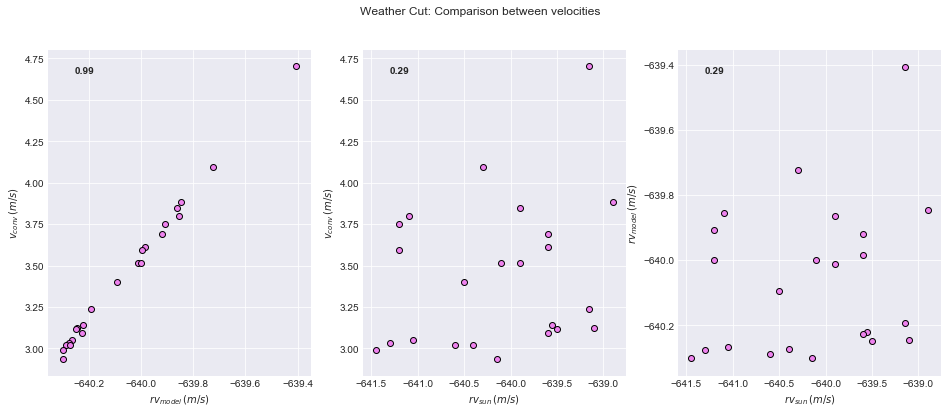

In [95]:
x_list = [g_rv_model, g_rv_sun, g_rv_sun]
y_list = [g_v_conv, g_v_conv, g_rv_model]
xlabel_list = ['$rv_{model} \/(m/s)$', '$rv_{sun} \/(m/s)$', '$rv_{sun} \/(m/s)$']
ylabel_list = ['$v_{conv} \/(m/s)$', '$v_{conv} \/(m/s)$', '$rv_{model} \/(m/s)$']
title = 'Weather Cut: Comparison between velocities'
# save_fig = os.path.join(ImgDir.MIL_IMG, 'comp_ref_calc_vels.png')

from scipy import stats
import matplotlib.pyplot as plt
# calculate correlation coefficient
corr_one = stats.spearmanr(x_list[0], y_list[0])
corr_two = stats.spearmanr(x_list[1], y_list[1])
corr_three = stats.spearmanr(x_list[2], y_list[2])

# setup the plot
fig, axs = plt.subplots(1, 3, figsize=[16, 6], gridspec_kw={'wspace': 0.2})
fig.suptitle(title)
axs[0].set(xlabel=xlabel_list[0], ylabel=ylabel_list[0])
axs[1].set(xlabel=xlabel_list[1], ylabel=ylabel_list[1])
axs[2].set(xlabel=xlabel_list[2], ylabel=ylabel_list[2])

# plot data
axs[0].scatter(x_list[0], y_list[0], color='violet', edgecolors='k', linewidths=1.0)
axs[1].scatter(x_list[1], y_list[1], color='violet', edgecolors='k', linewidths=1.0)
axs[2].scatter(x_list[2], y_list[2], color='violet', edgecolors='k', linewidths=1.0)

# label correlation coefficients
axs[0].text(0.1, 0.95, str(np.around(corr_one[0], 2)), horizontalalignment='left',
            verticalalignment='top', transform=axs[0].transAxes, weight='bold')
axs[1].text(0.1, 0.95, str(np.around(corr_two[0], 2)), horizontalalignment='left',
            verticalalignment='top', transform=axs[1].transAxes, weight='bold')
axs[2].text(0.1, 0.95, str(np.around(corr_three[0], 2)), horizontalalignment='left',
            verticalalignment='top', transform=axs[2].transAxes, weight='bold')

# remove tick marks
for ax in axs:
    ax.tick_params(labelbottom=True)

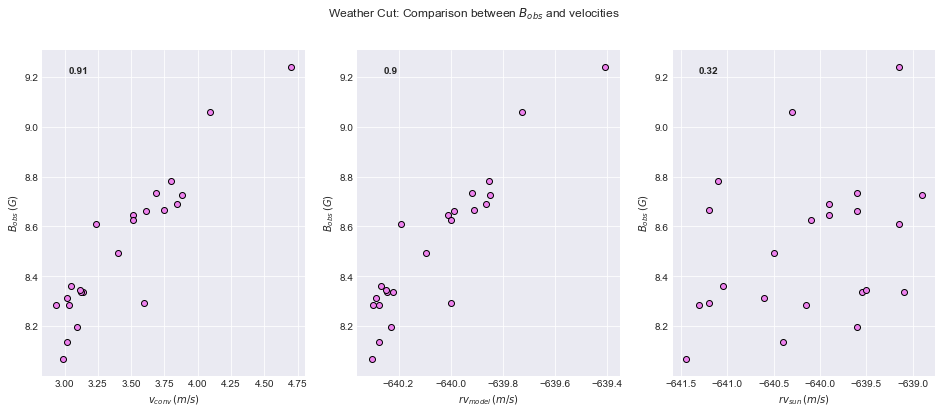

In [96]:
x_list = [g_v_conv, g_rv_model, g_rv_sun]
y_list = [g_Bobs, g_Bobs, g_Bobs]
xlabel_list = ['$v_{conv} \/(m/s)$', '$rv_{model} \/(m/s)$', '$rv_{sun} \/(m/s)$']
ylabel_list = ['$B_{obs} \/(G)$', '$B_{obs} \/(G)$', '$B_{obs} \/(G)$']
title = 'Weather Cut: Comparison between $B_{obs}$ and velocities'
# save_fig = os.path.join(ImgDir.MIL_IMG, 'comp_ref_calc_vels.png')

from scipy import stats
import matplotlib.pyplot as plt
# calculate correlation coefficient
corr_one = stats.spearmanr(x_list[0], y_list[0])
corr_two = stats.spearmanr(x_list[1], y_list[1])
corr_three = stats.spearmanr(x_list[2], y_list[2])

# setup the plot
fig, axs = plt.subplots(1, 3, figsize=[16, 6], gridspec_kw={'wspace': 0.2})
fig.suptitle(title)
axs[0].set(xlabel=xlabel_list[0], ylabel=ylabel_list[0])
axs[1].set(xlabel=xlabel_list[1], ylabel=ylabel_list[1])
axs[2].set(xlabel=xlabel_list[2], ylabel=ylabel_list[2])

# plot data
axs[0].scatter(x_list[0], y_list[0], color='violet', edgecolors='k', linewidths=1.0)
axs[1].scatter(x_list[1], y_list[1], color='violet', edgecolors='k', linewidths=1.0)
axs[2].scatter(x_list[2], y_list[2], color='violet', edgecolors='k', linewidths=1.0)

# label correlation coefficients
axs[0].text(0.1, 0.95, str(np.around(corr_one[0], 2)), horizontalalignment='left',
            verticalalignment='top', transform=axs[0].transAxes, weight='bold')
axs[1].text(0.1, 0.95, str(np.around(corr_two[0], 2)), horizontalalignment='left',
            verticalalignment='top', transform=axs[1].transAxes, weight='bold')
axs[2].text(0.1, 0.95, str(np.around(corr_three[0], 2)), horizontalalignment='left',
            verticalalignment='top', transform=axs[2].transAxes, weight='bold')

# remove tick marks
for ax in axs:
    ax.tick_params(labelbottom=True)

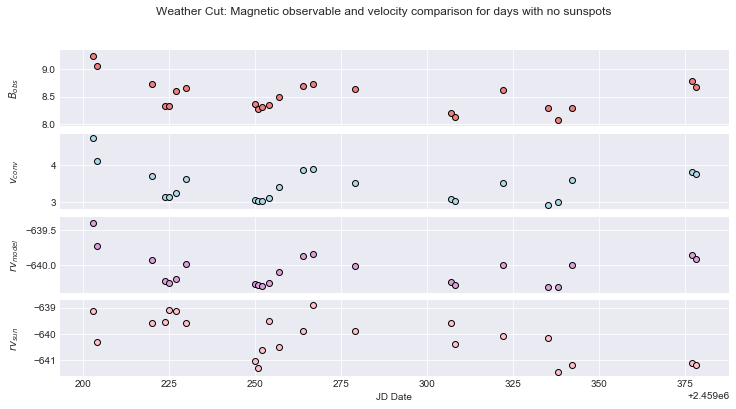

In [97]:
x = g_date_jd
y_list = [g_Bobs, g_v_conv, g_rv_model, g_rv_sun]
xlabel = 'JD Date'
ylabel_list = ['$B_{obs}$', '$v_{conv}$', '$rv_{model}$', '$rv_{sun}$']
title = 'Weather Cut: Magnetic observable and velocity comparison for days with no sunspots'

plot.vert_comp_timeseries(x, y_list, title, xlabel, ylabel_list)

In [98]:
print(len(g_date_jd))

23
